# Laboratory #06 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

In [22]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import io, data
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

**Exercise #1:**

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Make sure that the values of the integral image are correct.
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [23]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    # Add code here
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            integral_image_arr[i+1][j+1] = np.sum(img_arr[:i+1, :j+1])

    return integral_image_arr


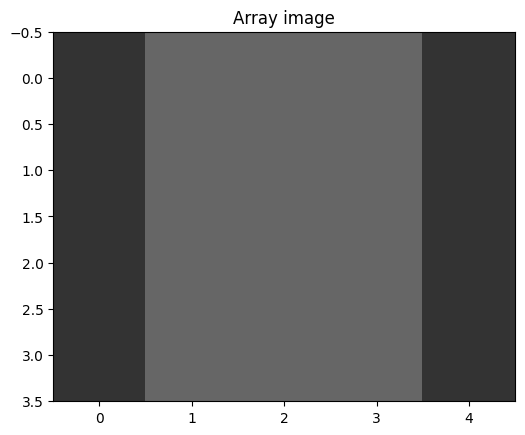

In [24]:
img_array = np.array([[1, 2, 2, 2, 1], 
                      [1, 2, 2, 2, 1], 
                      [1, 2, 2, 2, 1], 
                      [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [25]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

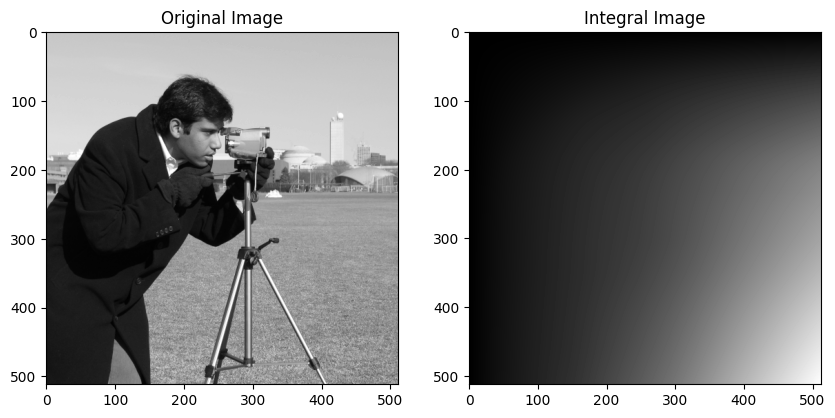

In [26]:
# solution
camera = data.camera()
integral_img_camera = compute_integral_image(camera)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(camera, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(integral_img_camera, cmap='gray')
ax[1].set_title('Integral Image')

plt.show()

**Exercise #2:**

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [27]:
def sum_region(integral_img_arr, top_left, bottom_right):

    # Code to complete
    top_right = top_left[0], bottom_right[1]
    bottom_left = bottom_right[0], top_left[1]

    return integral_img_arr[bottom_right[0]][bottom_right[1]] - integral_img_arr[top_right[0]][top_right[1]] - integral_img_arr[bottom_left[0]][bottom_left[1]] + integral_img_arr[top_left[0]][top_left[1]]

*   Make the following tests:

In [28]:
# result you should get (12)
sum_region(ii_img_array, [1, 1], [3, 4])

12.0

In [29]:
# result you should get (32)
sum_region(ii_img_array, [0, 0], [-1, -1])

32.0

**Exercise #3:**

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [30]:
def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):
        #### Complete here:
        #### Read image
        #### Remember to scale the images (with the max pixel intensity value)
        try:
            img = io.imread(f"{path}/{_file}")
            img = compute_integral_image(img)
            if np.max(img) != 0:
                img = img / np.max(img)
            ii_images.append(img)
        except Exception as e:
            pass
    return ii_images

# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

In [31]:
# change paths to your location

pos_training_path = 'CV/Labs/P06_face_detection_and_recognition/images/train_data/faces'
neg_training_path = 'CV/Labs/P06_face_detection_and_recognition/images/train_data/non_faces'
pos_testing_path = 'CV/Labs/P06_face_detection_and_recognition/images/test_data/faces'
neg_testing_path = 'CV/Labs/P06_face_detection_and_recognition/images/test_data/non_faces'

In [32]:
pos_training_ii = load_integral_images(pos_training_path)
neg_training_ii = load_integral_images(neg_training_path)
pos_testing_ii = load_integral_images(pos_testing_path)
neg_testing_ii = load_integral_images(neg_testing_path)

*   Visualize a few original images and the corresponding integral images using matplotlib.

Text(0.5, 1.0, 'Integral Image 3')

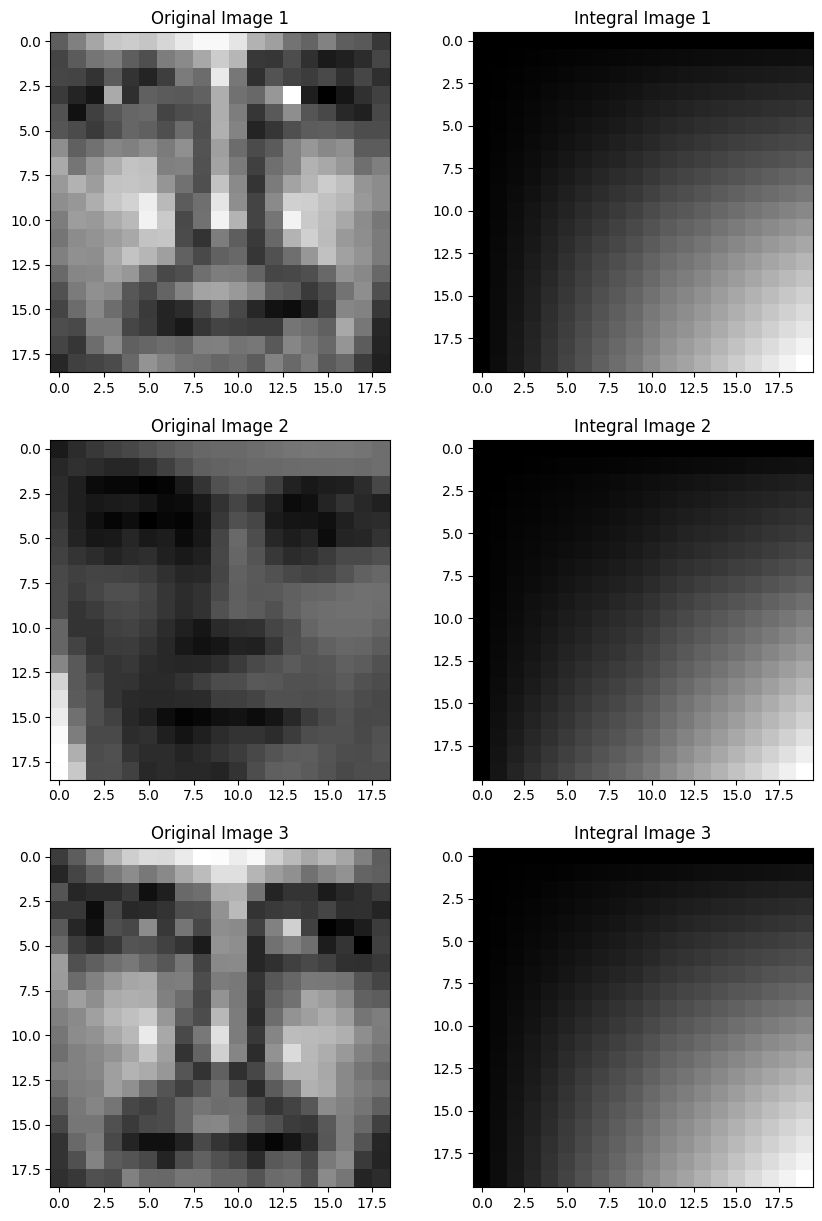

In [33]:
# solution

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

face1 = io.imread(f"{pos_training_path}/face00001.png")
face1_ii = compute_integral_image(face1)
face2 = io.imread(f"{pos_training_path}/face00010.png")
face2_ii = compute_integral_image(face2)
face3 = io.imread(f"{pos_training_path}/face00003.png")
face3_ii = compute_integral_image(face3)

ax[0, 0].imshow(face1, cmap='gray')
ax[0, 0].set_title(f'Original Image 1')
ax[0, 1].imshow(face1_ii, cmap='gray')
ax[0, 1].set_title(f'Integral Image 1')
ax[1, 0].imshow(face2, cmap='gray')
ax[1, 0].set_title(f'Original Image 2')
ax[1, 1].imshow(face2_ii, cmap='gray')
ax[1, 1].set_title(f'Integral Image 2')
ax[2, 0].imshow(face3, cmap='gray')
ax[2, 0].set_title(f'Original Image 3')
ax[2, 1].imshow(face3_ii, cmap='gray')
ax[2, 1].set_title(f'Integral Image 3')

**Exercise 4:**

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [34]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [35]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [36]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=os.cpu_count())
    print('\tNumber of CPUs:', os.cpu_count())
    for i in range(num_imgs):
        #print('\tCalculating scores for image', i)
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')

    t0 = time.time()
    
    features = []
    
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                for x in range(img_width - feature_width):
                    for y in range(img_height - feature_height):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))


    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    
    return features

**Exercise #5:**

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [37]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [38]:
%%time 

classifiers = learn(pos_training_ii, neg_training_ii, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0017905235290527344
Calculating scores for images..


	Number of CPUs: 32
	Time needed for calculating scores: 87.1603741645813
Selecting classifiers..
	Time needed for Selecting Classifiers: 8.515813827514648 

CPU times: user 1min 27s, sys: 18.6 s, total: 1min 46s
Wall time: 1min 35s


**Exercise #6:**

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [39]:
# solution

def ensemble_vote(int_img, classifiers):
    balance = 0
    for c in classifiers:
        vote = c.get_vote(int_img)
        balance += 1 if vote >= 0 else -1
    return 1 if balance > 0 else 0

def ensemble_vote_all(int_imgs, classifiers):
    return [ensemble_vote(img, classifiers) for img in int_imgs]

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [43]:
# solution

CIF_TR = sum(ensemble_vote_all(pos_training_ii, classifiers))
POS_TRAIN = len(pos_training_ii)
NEG_TRAIN = len(neg_training_ii)
CINF_TR = NEG_TRAIN-sum(ensemble_vote_all(neg_training_ii, classifiers))

CIF_TE = sum(ensemble_vote_all(pos_testing_ii, classifiers))
POS_TEST = len(pos_testing_ii)
NEG_TEST = len(neg_testing_ii)
CINF_TE = NEG_TEST-sum(ensemble_vote_all(neg_testing_ii, classifiers))

print('train results:')
print('Correctly identified Faces:', CIF_TR, '/', POS_TRAIN, (CIF_TR/POS_TRAIN)*100, '%' )
print('Correctly identified non-Faces:', CINF_TR, '/', NEG_TRAIN, (CINF_TR/NEG_TRAIN)*100, '%' )

print('\ntest results:')
print('Correctly identified Faces:', CIF_TE, '/', POS_TEST, (CIF_TE/POS_TEST)*100, '%' )
print('Correctly identified non-Faces:', CINF_TE, '/', NEG_TEST, (CINF_TE/NEG_TEST)*100, '%' )

train results:
Correctly identified Faces: 1854 / 2429 76.3277068752573 %
Correctly identified non-Faces: 6326 / 8555 73.94506136762128 %

test results:
Correctly identified Faces: 221 / 472 46.82203389830508 %
Correctly identified non-Faces: 102 / 128 79.6875 %


**Exercise #7:**

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [44]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [45]:
%%time 
classifiers_20 = learn(pos_training_ii, neg_training_ii, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0015218257904052734
Calculating scores for images..
	Number of CPUs: 32
	Time needed for calculating scores: 91.3239586353302
Selecting classifiers..
	Time needed for Selecting Classifiers: 96.55978631973267 

CPU times: user 2min 58s, sys: 19.4 s, total: 3min 18s
Wall time: 3min 7s


In [46]:
# solution

CIF_TR = sum(ensemble_vote_all(pos_training_ii, classifiers_20))
POS_TRAIN = len(pos_training_ii)
NEG_TRAIN = len(neg_training_ii)
CINF_TR = NEG_TRAIN-sum(ensemble_vote_all(neg_training_ii, classifiers_20))

CIF_TE = sum(ensemble_vote_all(pos_testing_ii, classifiers_20))
POS_TEST = len(pos_testing_ii)
NEG_TEST = len(neg_testing_ii)
CINF_TE = NEG_TEST-sum(ensemble_vote_all(neg_testing_ii, classifiers_20))

print('train results:')
print('Correctly identified Faces:', CIF_TR, '/', POS_TRAIN, (CIF_TR/POS_TRAIN)*100, '%' )
print('Correctly identified non-Faces:', CINF_TR, '/', NEG_TRAIN, (CINF_TR/NEG_TRAIN)*100, '%' )

print('\ntest results:')
print('Correctly identified Faces:', CIF_TE, '/', POS_TEST, (CIF_TE/POS_TEST)*100, '%' )
print('Correctly identified non-Faces:', CINF_TE, '/', NEG_TEST, (CINF_TE/NEG_TEST)*100, '%' )

train results:
Correctly identified Faces: 1826 / 2429 75.17496912309592 %
Correctly identified non-Faces: 7912 / 8555 92.48392752776155 %

test results:
Correctly identified Faces: 152 / 472 32.20338983050847 %
Correctly identified non-Faces: 118 / 128 92.1875 %


*   Discuss if the classification results improved in the train data.


**Solution**

The number of correctly identified faces drops from 46.82% to 32.20%  and the number of correctly identified non-faces goes from 79.68% to 92.18%. 

The analysis indicates a significant drop in the number of correctly identified faces, coupled with a substantial improvement in the accurate recognition of non-faces when using a larger number of classifiers. However, considering that the primary goal of the algorithm is to detect faces, the low percentage of correctly identified faces in this scenario doesn't align with the intended objective. Therefore, opting for a simpler approach with only two classifiers is preferable, as it not only requires less computation time but also enhances the focus on achieving the primary goal of accurate face detection.

**Exercise #8:**

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [48]:
# solution

def ensemble_vote_t(int_img, classifiers, threshold):
    return int(sum([c.get_vote(int_img) for c in classifiers]) > threshold)

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
    return [ensemble_vote_t(img, classifiers, threshold) for img in int_imgs]

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [49]:
# solution
thresholds = np.array([x for x in range(-5,5,1)])/10
total_pos_train = []
total_neg_train = []
total_pos_test = []
total_neg_test = []

for threshold in thresholds:
    pos_training_results = ensemble_vote_all_t(pos_training_ii, classifiers, threshold)
    neg_training_results = ensemble_vote_all_t(neg_training_ii, classifiers, threshold)
    pos_testing_results = ensemble_vote_all_t(pos_testing_ii, classifiers, threshold)
    neg_testing_results = ensemble_vote_all_t(neg_testing_ii, classifiers, threshold)
    
    total_pos_train.append(sum(pos_training_results) / len(pos_training_ii))
    
    total_neg_train.append((len(neg_training_ii) - sum(neg_training_results)) / len(neg_training_ii))
    
    total_pos_test.append(sum(pos_testing_results) / len(pos_testing_ii))
    
    total_neg_test.append((len(neg_testing_ii) - sum(neg_testing_results)) / len(neg_testing_ii))


*   Make a bar plot for 1-4. In the x axis write the threshold value.

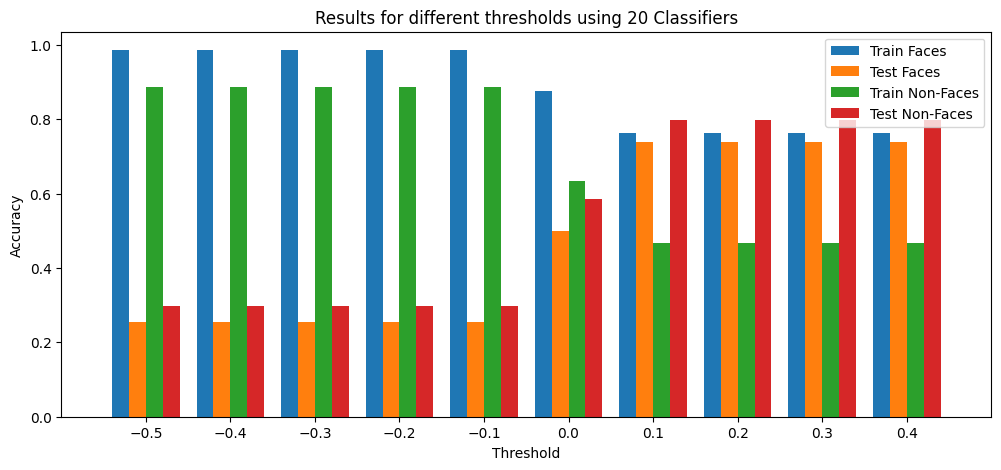

In [50]:
# solution

plt.figure(figsize=(12, 5))
plt.title('Results for different thresholds using 20 Classifiers')

plt.bar(thresholds - 0.030, total_pos_train, width=0.02,
        align='center', label='Train Faces')

plt.bar(thresholds - 0.010, total_neg_train, width=0.02,
         align='center', label='Test Faces')

plt.bar(thresholds + 0.010, total_pos_test, width=0.02,
         align='center', label='Train Non-Faces')

plt.bar(thresholds + 0.030, total_neg_test, width=0.02,
         align='center', label='Test Non-Faces')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xlim(-0.6, 0.5)
plt.xticks(thresholds)
plt.legend()
plt.show()

*   Discuss what happens when you increase the threshold value.

**Solution**

When we increase the threshold value, the test accuracy increases and the train accuracy decreases, suggesting that the model is generalizing better. This scenario often indicates that the model has become more adept at making accurate predictions on unseen data (test set) rather than merely memorizing the patterns from the training data. The balance between high test accuracy and lower train accuracy is indicative of a model that is less prone to overfitting and is better suited for real-world scenarios.

# Face Recognition

In [51]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [52]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [53]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 966 faces
done in 0.755s


In [55]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.049s


In [56]:
# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 5.090s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [58]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.014s


In [59]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.62      0.62        13
     Colin Powell       0.82      0.90      0.86        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.87      0.96      0.91       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.84      0.75      0.79        36

         accuracy                           0.84       322
        macro avg       0.83      0.73      0.77       322
     weighted avg       0.85      0.84      0.84       322



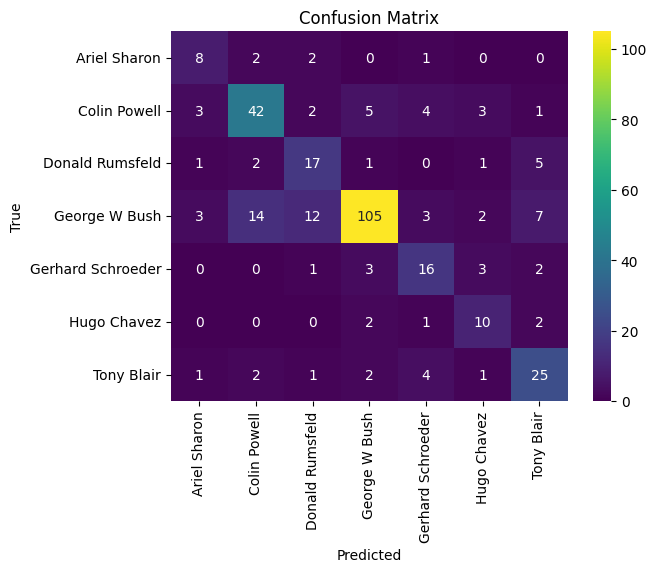

In [79]:
import seaborn as sns
# Plot confusion matrix
def plot_cm(y_test, y_pred, target_names):
    # Add labels to the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='viridis', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(y_test, y_pred, target_names=target_names)

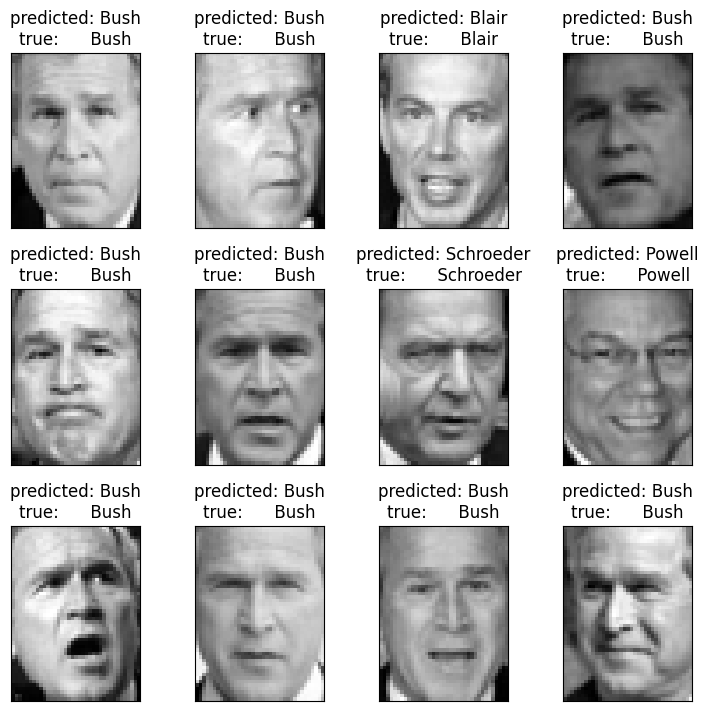

In [61]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

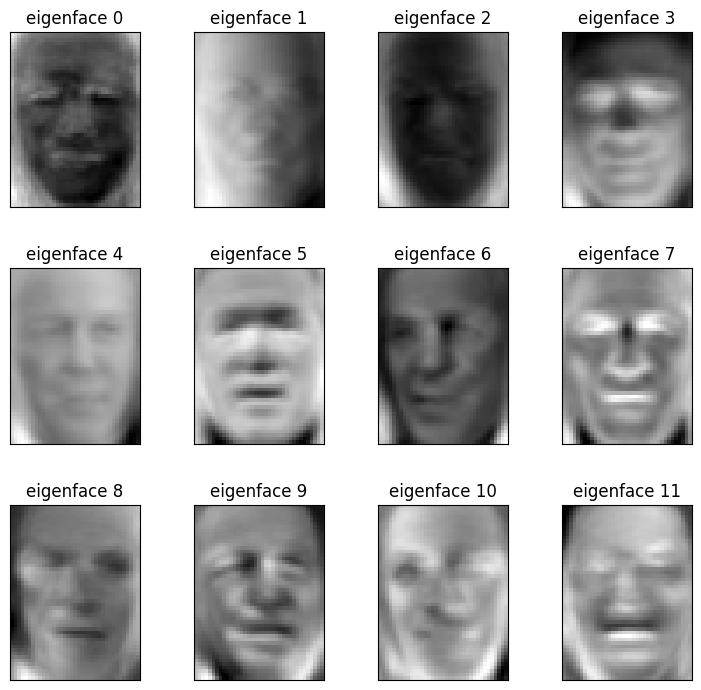

In [68]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

**Exercise #1:**

*   Show the total percentage of variance explained by the selected components of the PCA.


In [69]:
# solution
print(f"Total percentage of variance explained by {n_components} \
selected components of the PCA: {np.sum(pca.explained_variance_ratio_)}")


Total percentage of variance explained by 100 selected components of the PCA: 0.915320873260498


**Exercise #2:**

*   Explain all the measures showed in the classification report.
*   Discuss the obtained classification results, the quantitative as well as the qualitative results.
*   Comment the showed eigenfaces.



**Solution**
- Measures used:
  - Precision = True Positives / (True Positives + False Positives)
    Precision answers the question of how many of the selected instances are relevant. It focuses on the accuracy of positive predictions, indicating the proportion of instances predicted as positive that are actually positive.
  - Recall (Sensitivity or True Positive Rate): True Positives / (True Positives + False Negatives)
    Recall measures how many of the actual positive instances were captured by the model. It focuses on the sensitivity to detect positive instances, indicating the proportion of actual positive instances that were correctly predicted.
  - F1 Score: (1+Beta) * ((Precision * Recall) / (Precision + Beta*Recall))
    F1 Score is a harmonic mean of precision and recall. It provides a balanced measure that considers both false positives and false negatives. The beta parameter is a weight assigned to recall; it determines the amount of emphasis given to recall in the combined metric.
  - Support: Support is the number of actual occurrences of a class in the dataset.
    Support provides context about the distribution of classes in the dataset. It helps understand the prevalence of each class, indicating how many instances belong to a specific class.
    
- The model performs well overall, with a most of individuals getting scores over 0.80 and only 2 getting under 0.65 scores (the under-represented ones). The high F1-score for "George W Bush" could be due to overfitting, considering the class's significant representation. The confusion matrix highlights that the model is making accurate predictions, particularly along the diagonal, which represents the number of instances where the true class is equal to the predicted class, indicating successful recognition for many individuals.

- Eigenfaces, derived from PCA, effectively capture the essential features of faces, providing a representation that aligns well with the dataset. The high explained variance ratio (close to 1) indicates that PCA is successful in retaining critical information for facial recognition.

**Exercise #3:**

*   Change the strategy for dimensionality reduction from PCA to LDA. 
*   *Hint: You can use sklearn.discriminant_analysis.LinearDiscriminantAnalysis*

(966, 1850)
(966, 6)
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.68      0.70      0.69        60
  Donald Rumsfeld       0.49      0.63      0.55        27
    George W Bush       0.89      0.72      0.80       146
Gerhard Schroeder       0.55      0.64      0.59        25
      Hugo Chavez       0.50      0.67      0.57        15
       Tony Blair       0.60      0.69      0.64        36

         accuracy                           0.69       322
        macro avg       0.60      0.67      0.63       322
     weighted avg       0.72      0.69      0.70       322



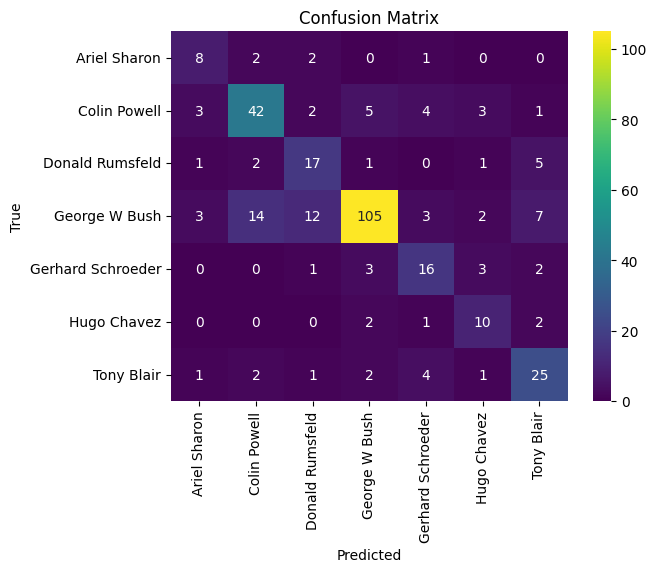

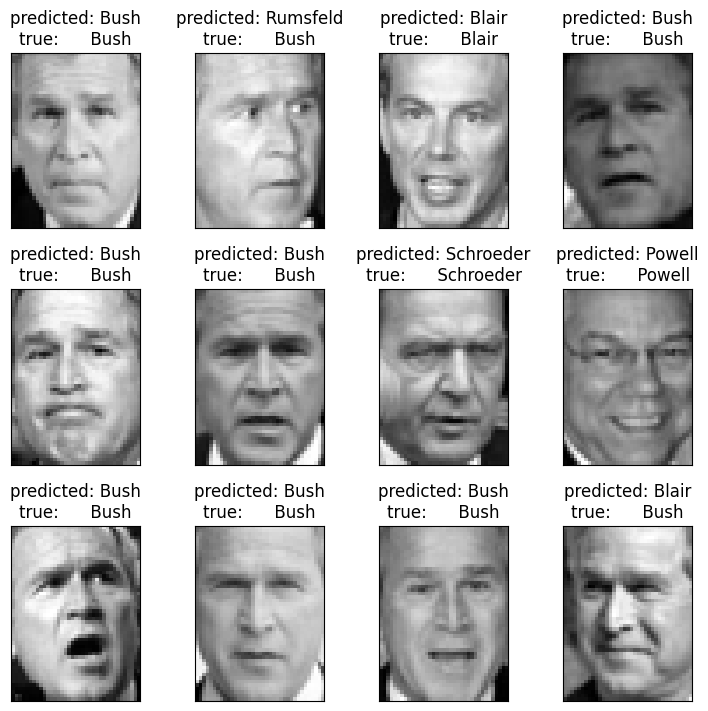

In [80]:
# solution

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA().fit(X_train, y_train)

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

print(X_train.shape)
print(X_train_lda.shape)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_lda, y_train)

y_pred = clf.predict(X_test_lda)
print(classification_report(y_test, y_pred, target_names=target_names))
plot_cm(y_test, y_pred, target_names=target_names)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

*   How many dimensions are we obtaining in the new space? Why?
*   Comment the results and compare them with the ones obtained with PCA.
*   Explain which is the main difference between the two approaches.

**Solution**

- We obtained 6 dimensions from the Linear Discriminant Analysis (LDA) algorithm, which is the maximum number of components it can provide (equal to the number of classes minus 1). LDA works in a supervised manner, finding hyperplanes that effectively separate all the data.

- The results from LDA are not as good as those from Principal Component Analysis (PCA). This might be because PCA can retain a higher number of components, while LDA is limited to preserving only 6 components, which may not fully capture the information.

- Both LDA and PCA are techniques for transforming data: LDA is supervised, considering class labels, while PCA is unsupervised, ignoring class labels. PCA looks for directions of maximal variance, capturing overall data patterns. On the other hand, LDA aims to find a feature space that maximizes the separability between classes. LDA assumes normally distributed classes and equal class covariances, so its performance may be affected if the data is extremely unbalanced, which could be a reason for the suboptimal performance in the second approach.